# Learning Discrete-Time Estimation and Control with Transformers

In [1]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

import matplotlib.pyplot as plt
from trajectories import *

T = 250 # how long to simulate the trajectory # 100
CUT = 5 # cutoff the first 5 elements of the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = 2
num_traj_train = 100; num_traj_test = 20
num_traj = num_traj_train + num_traj_test

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

### Trajectories that follow a fixed path on the unit circle

In [2]:
A, B, C, Q, R, x0 = circular_traj_params()
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

<Figure size 432x288 with 0 Axes>

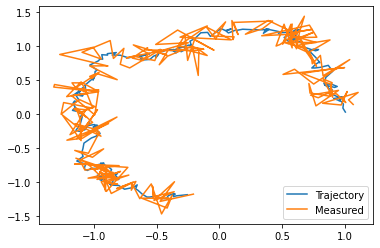

In [3]:
# plot a sample trajectory and noisy measurements
ind_to_vis = 119

plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:, 1], label='Trajectory')
linemeas = ax.plot(meas[ind_to_vis, CUT:, 0], meas[ind_to_vis, CUT:, 1], label='Measured')
plt.legend()
plt.show()

### Linear dynamics with constant velocity that randomly changes

In [ ]:
state_dim=2; input_dim=1; obs_dim=1
A, B, C, Q, R, x0 = motion_traj_params()
u_seq = np.zeros(shape=(num_traj, T, input_dim))
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)

In [ ]:
print(traj.shape)
print(meas.shape)

In [ ]:
ind_to_vis = 30

plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(range(T), traj[ind_to_vis, :, 0], label='Trajectory')
linemeas = ax.plot(range(T), meas[ind_to_vis, :, 0], label='Measured')
plt.legend()
plt.show()

### Moving around sphere

In [ ]:
state_dim=3; input_dim=1; obs_dim=3
num_traj=10
A, B, C, Q, R, x0 = so3_params()
u_seq = np.zeros(shape=(num_traj, T, input_dim))
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)

In [ ]:
ind_to_vis = 1
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(traj[ind_to_vis, :, 0], traj[ind_to_vis, :, 1], traj[ind_to_vis, :, 2], color='g')
plt.show()

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [4]:
err_fltr = 0
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj): # only the test trajs
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    fltr = kinematics_forward.simulate(meas[i], u_seq[i])
    kfiltered[i] = fltr
    err_fltr += np.linalg.norm(fltr[CUT:,:] - traj[i,CUT:,:])**2
    
print("Average Squared Error:", err_fltr / num_traj_test / T)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

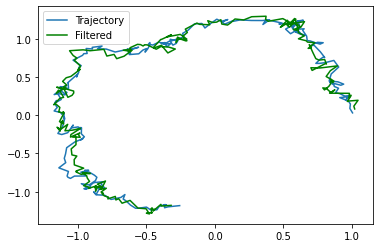

In [5]:
# FOR THE MOVING ON A CIRCLE SYSTEM
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:,1], label="Trajectory")
linefltr, = ax.plot(kfiltered[ind_to_vis, CUT:, 0], kfiltered[ind_to_vis, CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()


In [ ]:
# FOR THE MODULATING VELOCITY SYSTEM
from utils import plot

plt.figure()
fig, ax = plt.subplots()
linemeas, = ax.plot(range(T), meas[ind_to_vis, :, 0], label="Measured")
linetraj, = ax.plot(range(T), traj[ind_to_vis, :, 0], label="Trajectory")
linefltr, = ax.plot(range(T), kfiltered[ind_to_vis, :, 0], label="Filtered", color='g')
plt.legend()
plt.show()

# plt.figure()
# fig, ax = plt.subplots()
# linemeas, = ax.plot(range(T), meas[ind_to_vis, :, 0], label="Measured")
# linetraj, = ax.plot(range(T), traj[ind_to_vis, :, 0], label="Trajectory")
# linefltr, = ax.plot(range(T), kfiltered[ind_to_vis, :, 0], label="Filtered", color='g')
# plt.legend()
# plt.show()

In [ ]:
# FOR MOVING ALONG THE SPHERE

ind_to_vis = 1
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(traj[ind_to_vis, :, 0], traj[ind_to_vis, :, 1], traj[ind_to_vis, :, 2], label='Trajectory')
#ax.plot3D(meas[ind_to_vis, :, 0], meas[ind_to_vis, :, 1], meas[ind_to_vis, :, 2], label='Measured')
ax.plot3D(kfiltered[ind_to_vis, :, 0], kfiltered[ind_to_vis, :, 1], kfiltered[ind_to_vis, :, 2], color='g', label='Filtered')
plt.legend()
plt.show()

# plt.figure()
# fig, ax = plt.subplots()
# linemeas, = ax.plot(range(T), meas[ind_to_vis, :, 2], label="Measured")
# linetraj, = ax.plot(range(T), traj[ind_to_vis, :, 2], label="Trajectory")
# linefltr, = ax.plot(range(T), kfiltered[ind_to_vis, :, 2], label="Filtered", color='g')
# plt.legend()
# plt.show()

### 1b. Kalman Filter with pure steady state gains

In [6]:
err_fltr_ss = 0
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    fltr_ss = kinematics_forward.simulate(meas[i], u_seq[i])
    kfiltered_ss[i] = fltr_ss
    err_fltr_ss += np.linalg.norm(fltr_ss[CUT:,:] - traj[i,CUT:,:])**2

print("Average Squared Error", err_fltr_ss / num_traj_test / T)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in

<Figure size 432x288 with 0 Axes>

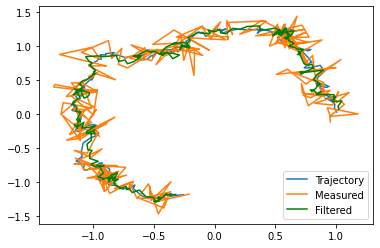

In [11]:
# For the system moving on the circle 
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:,1], label="Trajectory")
linemeas, = ax.plot(meas[ind_to_vis,:,0], meas[ind_to_vis,:,1], label="Measured")
linefltr, = ax.plot(kfiltered_ss[ind_to_vis, CUT:, 0], kfiltered_ss[ind_to_vis, CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

In [ ]:
# FOR THE SINGLE OUTPUT SYSTEM
ind_to_vis = 1
print("Positions")
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(range(T), traj[ind_to_vis, :, 0], label="Trajectory")
linemeas, = ax.plot(range(T), meas[ind_to_vis, :, 0], label="Measured")
linefltr, = ax.plot(range(T), kfiltered[ind_to_vis, :, 0], label="Filtered", color='g')
plt.legend()
plt.show()

print("Velocities")
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(range(T), traj[ind_to_vis, :, 1], label="Trajectory")
linemeas, = ax.plot(range(T), meas[ind_to_vis, :, 1], label="Measured")
linefltr, = ax.plot(range(T), kfiltered[ind_to_vis, :, 1], label="Filtered", color='g')
plt.legend()
plt.show()

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

In [12]:
err_id_fltr = 0
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered[i] = id_fltr
    err_id_fltr += np.linalg.norm(id_fltr[CUT:,:] - traj[i,CUT:,:])**2
print("Average Squared Error", err_id_fltr / num_traj_test / T)

Average Squared Error 0.10293401278751974


<Figure size 432x288 with 0 Axes>

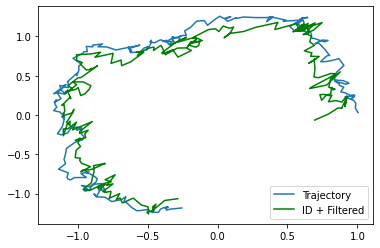

In [13]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:, 1], label="Trajectory")
linefltr, = ax.plot(id_filtered[ind_to_vis, CUT:, 0], id_filtered[ind_to_vis, CUT:, 1], label="ID + Filtered", color='g')
plt.legend()
plt.show()

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [14]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i][:t], u_seq[i][:t])[-1]
    id_filtered_simulated[i] = id_fltr_sim
    err_id_fltr_sim += np.linalg.norm(id_fltr_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_id_fltr_sim / num_traj_test / T)

Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 15 iterations
Converged in 14 iterations
Converged in 14 iterations
Converged in 14 iterations
Converged in 15 iterations
Converged in 15 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 14 iterations
Converged in 15 iterations
Converged in 16 iterations
Converged in 15 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 15 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 14 iterations
Converged in 16 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 16 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 18 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
Converged in 17 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
Converged in 16 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

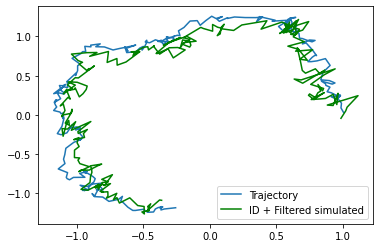

In [15]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[ind_to_vis,CUT:,0], traj[ind_to_vis,CUT:,1], label="Trajectory") # cut out first point since it starts at the origin
# linemeas, = ax.plot(meas[ind_to_vis, CUT:,0], meas[ind_to_vis, CUT:,1], label="Measured")
linefltr, = ax.plot(id_filtered_simulated[ind_to_vis,CUT:,0], id_filtered_simulated[ind_to_vis,CUT:,1], label="ID + Filtered simulated", color='g')
plt.legend()
plt.show()

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

In [ ]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = ind_to_vis
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Errors", err_learned_kf / T) #num_traj_test / T)

In [ ]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[ind_to_vis, CUT:, 0], traj[ind_to_vis, CUT:, 1], label="Trajectory")
linetrueKF, = ax.plot(kfiltered[ind_to_vis, CUT:, 0], kfiltered[ind_to_vis, CUT:, 1], label="Optimal KF")
linefltr, = ax.plot(learned_kfs_simulated[ind_to_vis, CUT:, 0], learned_kfs_simulated[ind_to_vis, CUT:, 1], label="LearnedKF simulated")
lineopt, = ax.plot(id_filtered_simulated[ind_to_vis, CUT:, 0], id_filtered_simulated[ind_to_vis, CUT:, 1], label="ID + Filtered simulated")
plt.legend()
plt.show()

print("Average Squared Errors", err_learned_kf / T) # / num_traj_test)

In [ ]:
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

# Transformer-based techniques to learn the dynamics and filter the position

In [16]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

In [17]:
# Training Data
indices_train = np.arange(num_traj_train)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
true_positions_train = torch.from_numpy(traj)[indices_train,:,:]


# Test Data
indices_test = np.arange(num_traj_train, num_traj)
traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)[indices_test,:,:]

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [19]:
num_epochs = 200

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=state_dim,
                n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  #TRYING TO HIT NOISY DATA

        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)
        loss = loss_func(decoder_output, target_sequence_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 659.4880323782072
Epoch 1 : Loss 454.47899694793807
Epoch 2 : Loss 194.81443837665807
Epoch 3 : Loss 148.92658535258866
Epoch 4 : Loss 124.76285376742958
Epoch 5 : Loss 120.18881099994957
Epoch 6 : Loss 112.51355452522463
Epoch 7 : Loss 110.83203846046277
Epoch 8 : Loss 108.48516509512882
Epoch 9 : Loss 107.21208402971774
Epoch 10 : Loss 107.46410240373366
Epoch 11 : Loss 107.22891369071166
Epoch 12 : Loss 105.63384931857193
Epoch 13 : Loss 103.18648684105375
Epoch 14 : Loss 101.22630821478432
Epoch 15 : Loss 100.18912682973168
Epoch 16 : Loss 99.63618162181226
Epoch 17 : Loss 99.10921608615357
Epoch 18 : Loss 98.59763662931843
Epoch 19 : Loss 98.15283498520574
Epoch 20 : Loss 97.72721005055276
Epoch 21 : Loss 97.34416029863674
Epoch 22 : Loss 96.98050263568956
Epoch 23 : Loss 96.65360509439932
Epoch 24 : Loss 96.33936031093012
Epoch 25 : Loss 96.0525146174682
Epoch 26 : Loss 95.80356057361092
Epoch 27 : Loss 95.55763893667822
Epoch 28 : Loss 95.32082047918038
Epoch 29 :

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

In [ ]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
ind_to_vis = 3 # 0 through 19

filtered = gpt_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by GPT', color='g')
linetrueKF, = ax.plot(kfiltered[ind_to_vis+num_traj_train, CUT:, 0], kfiltered[ind_to_vis+num_traj_train, CUT:, 1], label="Optimal KF", color='r')

plt.legend()
plt.show()

#print('Average Squared Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
#print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)

## Least-Squares: Fit a linear model that predicts true position from the noisy reading 
(This is the baseline for BERT)

In [ ]:
inputs_train_flattened = transformer_input_train.reshape(num_traj_train, T * (obs_dim + input_dim)).detach().numpy()
traj_train_flattened = true_positions_train.reshape(num_traj_train, T * state_dim).detach().numpy()

# Learned weights
weights_learned = np.linalg.lstsq(inputs_train_flattened, traj_train_flattened)[0]

inputs_test_flattened = transformer_input_test.reshape(num_traj_test, T * (obs_dim + input_dim)).detach().numpy()
traj_test_flattened = true_positions_test.reshape(num_traj_test, T * state_dim).detach().numpy()

pred_test = inputs_test_flattened @ weights_learned
pred_test_traj = pred_test.reshape(num_traj_test, T, state_dim)

## Can you fit it and show what is filtered by Least Squares?
error = np.linalg.norm(traj_test_flattened - pred_test)**2
print("Average Error of Least Squares is", error / num_traj_test / T)

ind_to_vis = 2 # 0 through 19

plt.figure()
fig, ax = plt.subplots()
linetraj = ax.plot(traj_test[ind_to_vis, CUT:, 0], traj_test[ind_to_vis, CUT:, 1], label='Trajectory')
# linemeas = ax.plot(meas_test[ind_to_vis, CUT:, 0], meas_test[ind_to_vis, CUT:, 1], label='Measured')
linefltr, = ax.plot(kfiltered[ind_to_vis+num_traj_train, CUT:,0], kfiltered[ind_to_vis+num_traj_train, CUT:,1], label="Kalman Filter", color='g')
linelstsq = ax.plot(pred_test_traj[ind_to_vis, CUT:, 0], pred_test_traj[ind_to_vis, CUT:, 1], label='Filtered by least squares', color='r')
plt.legend()
plt.show()


## BERT-style: Transformer Encoder only, fill in trajectory

Note - we are taking advantage of the ground truth (TRUE TRAJECTORY) here! 
The following cell takes about 15 minutes to run.

In [ ]:
num_epochs = 200
# p = 0.15 # probability of zeroing out a token

# bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
#                 embed_size=embed_dim, output_size=state_dim, 
#                 n_layers=4, n_heads=6, d_filter=64, 
#                 dropout=None)
# optimizer = torch.optim.Adam(bert_model.parameters())

loss_func = torch.nn.MSELoss(reduction='sum')
# losses = []

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        # Randomly zero-out p% of the tokens in transformer_input_train - different for each batch each time
        # If we're trying to hit the true targets, DO NOT MASK!
        # mask = torch.bernoulli( (1-p) * torch.ones(size=(batch_size, T) ) )
        # mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :] # * mask
        
     
        # NO! do NOT use a zero-mask. instead, your mask should be LEARNABLE! you should REPLACE tokens with the mask, NOT MULTIPLY!
        # FIX THIS
        
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        true_positions_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, true_positions_batch) #,target_sequences_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [ ]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
ind_to_vis = 9

filtered = bert_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linelstsq = ax.plot(pred_test_traj[ind_to_vis, CUT:, 0], pred_test_traj[ind_to_vis, CUT:, 1], label='Filtered by least squares', color='m')
linebert, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by BERT', color='g')
linetrueKF, = ax.plot(kfiltered[ind_to_vis+num_traj_train, CUT:,0], kfiltered[ind_to_vis+num_traj_train, CUT:,1], label="Optimal KF", color='r')
# linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='b')

plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)